In [1]:
import anndata as ad
import scanpy as sc

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

from scGPD import scGPD, ExpressionDataset,PoiLoss

**Load and process dataset**

**Create training and validation splits**

In [2]:
# Load the preprocessed single-cell RNA-seq dataset
# This AnnData object contains highly variable genes (HVGs)
adata = sc.read_h5ad("/gpfs/gibbs/project/zhao/yg399/gene_panel_design/dataset/single_cell/human_hvg.h5ad")

In [3]:
# We start with the 5000 highly vairable genes
adata = adata[:,adata.var['highly_variable']]

In [4]:
category_to_num = {category: idx for idx, category in enumerate(np.unique(adata.obs['cell_type1']))}

# Convert the categories to numbers
label = np.array([category_to_num[category] for category in adata.obs['cell_type1']])

adata.obs['label'] = label
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)
adata.layers['log1pcpm'] = csr_matrix(adata.layers['log1pcpm'])

/tmp/ipykernel_1758658/24599748.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['label'] = label


In [5]:
adata

AnnData object with n_obs × n_vars = 8569 × 5000
    obs: 'human', 'cell_type1', 'label'
    var: 'highly_variable'
    uns: 'hvg', 'log1p'
    layers: 'log1pcpm'

In [21]:
#use stratifiedkfold to split the data according to available labels
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_idx, test_idx = next(skf.split(adata.X, adata.obs["label"]))

adata_train = adata[train_idx]
adata_val = adata[test_idx]

In [ ]:
# Load the estimated gene–gene covariance matrix
# The covariance matrix used here is estimated using CS-CORE (Su et al., 2023)
#
# Tutorial and implementation of CS-CORE:
# https://github.com/ChangSuBiostats/CS-CORE
#
# Note: scGPD does not depend on a specific covariance estimator.
# Other reasonable gene–gene covariance or correlation estimates
# can also be used in place of CS-CORE.
cov = pd.read_csv(
    "/gpfs/gibbs/project/zhao/yg399/gene_panel_design/dataset/single_cell/human_cov.csv",
    index_col=0
)
# Add a small diagonal jitter for numerical stability
# (required for Cholesky decomposition)
epsilon = 1e-5
cov = cov + epsilon * np.eye(cov.shape[0])

# Compute the Cholesky factor of the covariance matrix
L = np.linalg.cholesky(cov.values)

# Convert to a PyTorch tensor for downstream use in scGPD
L = torch.from_numpy(L).float()

In [25]:
from tqdm import tqdm  
# Build PyTorch datasets for scGPD
train_dataset = ExpressionDataset(adata_train.X, adata_train.X)
val_dataset   = ExpressionDataset(adata_val.X,   adata_val.X)
device = "cpu"
# ----------------------------
# Stage 1: Candidate elimination
# ----------------------------
# Initialize the Stage-1 scGPD selector with:
# - an MLP predictor (hidden=[128, 128])
# - Poisson loss (PoiLoss) for count-based reconstruction
# Coarse removal of genes via correlation-aware gating
# target=500: aim to reduce the candidate pool to ~500 genes after elimination.
# In practice, retaining ~500–1000 genes after Stage 1 typically provides a good
# balance between computational efficiency and preserving informative candidates
# for the subsequent k-gene selection stage. 
# max_nepochs=150: maximum number of training epochs for Stage 1
# lam_init: initial sparsity regularization strength that controls how many genes remain.
# Larger values of lambda enforce stronger sparsity and remove more genes,
# while smaller values retain more genes. The value can be adjusted to achieve
print(f"Using device: {device}")
# step 1 
selector_1 = scGPD(train_dataset,
                   val_dataset,
                   hidden = [128,128],
                   L = L.float(),
                   loss_fn=PoiLoss(),
                   device=device)

# Coarse removal of genes
print('Starting')
candidates, _ = selector_1.eliminate(target=500,max_nepochs=150,lam_init=0.0000357,verbose=False)
print('Completed')

Using device: cpu
Starting
trying lam = 0.000036


lam = 0.000036 yielded 578 genes
Completed


In [32]:
# ----------------------------
# Step 2: Final k-gene selection (task-specific)
# ----------------------------
# In Stage 2, we restrict to the Stage-1 candidate pool and select exactly k genes
# optimized for a downstream task (here: cell-type classification).

# Build datasets using lognormalized expression values for the candidate genes
# Inputs:  expression matrix restricted to the candidate gene set
# Targets: cell-type labels (stored in adata.obs['label'])
train_dataset = ExpressionDataset(adata_train.layers['log1pcpm'][:,candidates], adata_train.obs['label'].values)
val_dataset = ExpressionDataset(adata_val.layers['log1pcpm'][:,candidates], adata_val.obs['label'].values)

# Specify the desired panel size(s) for selection; here we select a 256-gene panel
num_genes_list = [256]
scGPD_result = {}

# Use CrossEntropy loss for a multi-class classification objective
# Note: L is still provided to enable correlation-aware selection among the candidates
selector = scGPD(train_dataset,
                   val_dataset,
                   loss_fn=torch.nn.CrossEntropyLoss(),
                   L = L.float(),
                   device=device)

# For each target panel size, select exactly "num" genes from the candidate pool
# max_nepochs controls the training budget for Stage 2 optimization
print('Selecting genes')
for num in num_genes_list:
    inds, model = selector.select(num_genes=num, max_nepochs=280,verbose=True)
    scGPD_result[num] = inds
print('Done')

Selecting genes
assuming loss function CrossEntropyLoss() requires 14 outputs


Training epochs:   0%|          | 0/280 [00:00<?, ?it/s]

done, selected 256 genes
Done


/gpfs/gibbs/project/zhao/yg399/conda_envs/gene_panel/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/zhao/yg399/conda_envs/gene_panel/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<AxesSubplot:title={'center':'cell_type1'}, xlabel='UMAP1', ylabel='UMAP2'>

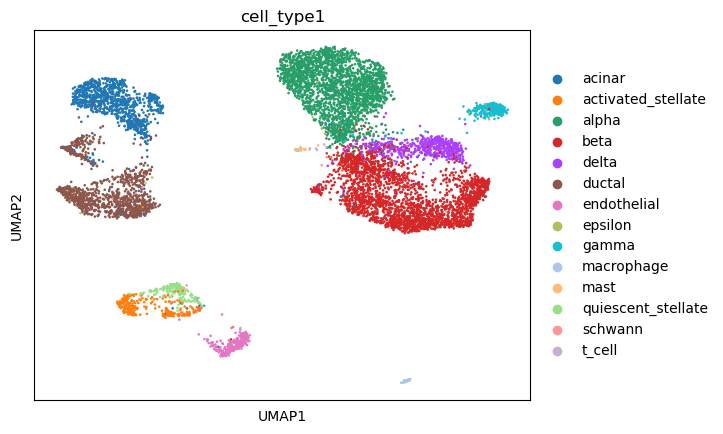

In [39]:
# UMAP visualising with selected genes
import umap
adata_sub = adata[:,candidates][:,scGPD_result[256]]
sc.pp.scale(adata_sub, max_value=10)
sc.tl.pca(adata_sub, svd_solver="arpack", n_comps=50)

# umap
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=False)
embedding = reducer.fit_transform(adata_sub.obsm['X_pca'])
adata_sub.obsm["X_umap"] = embedding
sc.pl.umap(adata_sub, color=["cell_type1"],show=False)

In [41]:
# list genes
adata[:,candidates][:,scGPD_result[256]].var_names

Index(['ADM', 'AGTRAP', 'AKR1C1', 'AKR1C3', 'ALDH1A1', 'AMBP', 'AMPD2',
       'AMY2A', 'ANGPTL4', 'ANKRD37',
       ...
       'VCAN', 'VEGFA', 'VGF', 'VWA5A', 'WARS', 'YPEL2', 'ZFP36', 'ZNF395',
       'ZNF396', 'pk'],
      dtype='object', length=256)